# Systems Immunogenetics Project

## QTL Mapping Workflow

### McWeeney Lab, Oregon Health & Science University

#### Author: Michael Mooney (mooneymi@ohsu.edu)

## Introduction

This document will walk through the steps for mapping QTLs in the RIX lines.

Required Files:

1. This notebook** (`SIG_QTL_Mapping_Workflow.ipynb`): [[Download here]](https://raw.githubusercontent.com/biodev/SIG/master/SIG_QTL_Mapping_Workflow.ipynb)
2. The R script `rix_qtl_mapping_functions.r`: [[Download here]](https://raw.githubusercontent.com/biodev/SIG/master/scripts/rix_qtl_mapping_functions.r)
3. File for mapping between CC IDs and RIX IDs: 
    - File with Oas1b status for WNV mapping (`Oas1b_status_recoded.txt`)
    - File with Mx1 status for Influenza mapping (`Mx1_status_recoded.txt`)

** Note: this notebook can also be downloaded as an R script (only the code blocks seen below will be included): [[Download R script here]]

Required R Libraries:

1. `gdata`: [https://cran.r-project.org/web/packages/gdata/index.html](https://cran.r-project.org/web/packages/gdata/index.html)
2. `DOQTL`: [https://www.bioconductor.org/packages/release/bioc/html/DOQTL.html](https://www.bioconductor.org/packages/release/bioc/html/DOQTL.html)
3. `GenomicRanges`: [https://bioconductor.org/packages/release/bioc/html/GenomicRanges.html](https://bioconductor.org/packages/release/bioc/html/GenomicRanges.html)
4. `VariantAnnotation`: [https://bioconductor.org/packages/release/bioc/html/VariantAnnotation.html](https://bioconductor.org/packages/release/bioc/html/VariantAnnotation.html)
5. `foreach`: [https://cran.r-project.org/web/packages/foreach/index.html](https://cran.r-project.org/web/packages/foreach/index.html)
6. `doParallel`: [https://cran.r-project.org/web/packages/doParallel/index.html](https://cran.r-project.org/web/packages/doParallel/index.html)
7. `RColorBrewer`: [https://cran.r-project.org/web/packages/RColorBrewer/index.html](https://cran.r-project.org/web/packages/RColorBrewer/index.html)

**All code is available on GitHub: [https://github.com/biodev/SIG](https://github.com/biodev/SIG)**

## Step 1. Load Necessary R Functions and Libraries

In [1]:
## Load R functions and libraries
source('./scripts/rix_qtl_mapping_functions.r')

gdata: read.xls support for 'XLS' (Excel 97-2004) files ENABLED.

gdata: read.xls support for 'XLSX' (Excel 2007+) files ENABLED.

Attaching package: ‘gdata’

The following object is masked from ‘package:stats’:

    nobs

The following object is masked from ‘package:utils’:

    object.size

Loading required package: BSgenome.Mmusculus.UCSC.mm10
Loading required package: BSgenome
Loading required package: BiocGenerics
Loading required package: parallel

Attaching package: ‘BiocGenerics’

The following objects are masked from ‘package:parallel’:

    clusterApply, clusterApplyLB, clusterCall, clusterEvalQ,
    clusterExport, clusterMap, parApply, parCapply, parLapply,
    parLapplyLB, parRapply, parSapply, parSapplyLB

The following object is masked from ‘package:gdata’:

    combine

The following objects are masked from ‘package:stats’:

    IQR, mad, xtabs

The following objects are masked from ‘package:base’:

    anyDuplicated, append, as.data.frame, as.vector, cbind, colnames,
  

## Step 2. Create Genome Cache

If the RIX list below is complete, you should only have to create the cache once (one for males and one for females). You can then subset the cache based on the particular mapping population being studied (as shown in Step 6 below). If you've already created the genome cache, skip to step 3.

In [2]:
## First get all RIX matings
rix_list = read.xls('./data/BOBs_Corrected_16_06_22.xlsx', header=T, as.is=T)
rix_list = rix_list[,1:2]
colnames(rix_list) = c('Mating', 'CC_Mating')
head(rix_list)

,Mating,CC_Mating
1,477x16912,CC036xCC051
2,1566x8002,CC021xCC032
3,1566x8043,CC021xCC023
4,3015x5306,CC074xCC062
5,3015x5358,CC074xCC058
6,3015x15156,CC074xCC002


In [3]:
## Set directory containing founder 36-state probability files, and get filenames
#cc_dir = '/mnt/lustre1/users/mooneymi/SIG/mapping/CC'
cc_dir = '/Users/mooneymi/Documents/SIG/Mapping/CC'
cc_prob_files = list.files(cc_dir, pattern="CC...-.*b38.*\\.csv")
length(cc_prob_files)
cc_prob_files[1:5]

[1] 72

[1] "CC001-Uncb38V01.csv"    "CC002-Uncb38V01.csv"    "CC003-Uncb38V01.csv"   
[4] "CC004-TauUncb38V01.csv" "CC005-TauUncb38V01.csv"

In [4]:
## Get vectors of parental strains
rix_strains = unlist(strsplit(rix_list$Mating, 'x'))
cc_strains = unlist(strsplit(rix_list$CC_Mating, 'x'))

## Check strains (some cc_strains will be duplicated -- re-derived lines)
dup_idx = duplicated(rix_strains)
cc_strains = cc_strains[!dup_idx]
names(cc_strains) = rix_strains[!dup_idx]
length(cc_strains)
cc_strains[1:5]

[1] 69

477   16912    1566    8002    8043 
"CC036" "CC051" "CC021" "CC032" "CC023"

In [5]:
## Check that all matings mapped to a CC mating
sum(is.na(cc_strains))

[1] 0

In [6]:
## Set directory containing the 8-state probability files
## These files can be created using the collapse_probs() function (see next code block)
#rix_dir = '/mnt/lustre1/users/mooneymi/SIG/mapping/RIX'
rix_dir = '/Users/mooneymi/Documents/SIG/Mapping/RIX'

In [ ]:
## If you need to create the 8-state probability files (you should only have to do this once)
## File names will be the RIX IDs (not CC IDs). 
## Note: you may have to copy some files for re-derived lines (e.g. 8042 and 18042 are the same)
# for (i in 1:length(cc_strains)) {
#     ## Get RIX ID
#     rix = names(cc_strains[i])
#     
#     ## Create and save the 8-state probabilities for each parental strain
#     cc_file = file.path(cc_dir, cc_prob_files[grep(paste0(cc_strains[i], '-.*\\.csv'), cc_prob_files)])
#     cc_8state = collapse_probs(cc_file)
#     
#     ## Save Y and M chromosomes separately
#     autosome_x_markers = cc_8state$marker[!cc_8state$chromosome %in% c('Y', 'M')]
#     y_m_markers = cc_8state$marker[cc_8state$chromosome %in% c('Y', 'M')]
#     file_name = file.path(rix_dir, paste0(rix, '.csv'))
#     write.table(cc_8state[autosome_x_markers, ], file=file_name, row.names=F, col.names=T, sep=',', quote=F)
#     file_name = file.path(rix_dir, paste0(rix, '_Y_M.csv'))
#     write.table(cc_8state[y_m_markers, ], file=file_name, row.names=F, col.names=T, sep=',', quote=F)
# }

In [7]:
## Create 3D probability array - Males
model.probs = make_rix_model_probs(rix_list$Mating, rix_dir, 'M')
dim(model.probs)
names(dimnames(model.probs))

[1] 1
[1] 2
[1] 3
[1] 4
[1] 5
[1] 6
[1] 7
[1] 8
[1] 9
[1] 10
[1] 11
[1] 12
[1] 13
[1] 14
[1] 15
[1] 16
[1] 17
[1] 18
[1] 19
[1] 20
[1] 21
[1] 22
[1] 23
[1] 24
[1] 25
[1] 26
[1] 27
[1] 28
[1] 29
[1] 30
[1] 31
[1] 32
[1] 33
[1] 34
[1] 35
[1] 36
[1] 37
[1] 38
[1] 39
[1] 40
[1] 41
[1] 42
[1] 43
[1] 44
[1] 45
[1] 46
[1] 47
[1] 48
[1] 49
[1] 50
[1] 51
[1] 52
[1] 53
[1] 54
[1] 55
[1] 56
[1] 57
[1] 58
[1] 59
[1] 60
[1] 61
[1] 62
[1] 63
[1] 64
[1] 65
[1] 66
[1] 67
[1] 68
[1] 69
[1] 70
[1] 71
[1] 72
[1] 73
[1] 74
[1] 75
[1] 76
[1] 77
[1] 78
[1] 79
[1] 80
[1] 81
[1] 82
[1] 83
[1] 84
[1] 85
[1] 86
[1] 87
[1] 88
[1] 89
[1] 90
[1] 91
[1] 92
[1] 93
[1] 94
[1] 95
[1] 96
[1] 97
[1] 98
[1] 99
[1] 100
[1] 101
[1] 102
[1] 103
[1] 104
[1] 105
[1] 106
[1] 107
[1] 108
[1] 109
[1] 110
[1] 111
[1] 112
[1] 113
[1] 114
[1] 115
[1] 116
[1] 117
[1] 118
[1] 119
[1] 120


[1]   120     8 76606

[1] "samples"  "founders" "markers"

In [8]:
## Check model.probs object
model.probs[1,,1:5]

,UNC6,JAX00000010,JAX00240603,JAX00240610,JAX00240613
A,3.00075e-06,2.62500e-06,2.25000e-06,1.87500e-06,1.50000e-06
B,3.751e-06,3.375e-06,3.000e-06,2.625e-06,2.250e-06
C,2.292e-06,1.875e-06,1.500e-06,1.125e-06,7.500e-07
D,2.292e-06,1.875e-06,1.500e-06,1.125e-06,7.500e-07
E,0.4999923,0.4999936,0.4999947,0.4999955,0.4999962
F,0.4999948,0.4999959,0.4999970,0.4999978,0.4999985
G,7.92e-07,3.75e-07,0.00e+00,0.00e+00,0.00e+00
H,7.5075e-07,3.7500e-07,0.0000e+00,0.0000e+00,0.0000e+00


In [9]:
## Get vector of all markers
all_markers = dimnames(model.probs)[[3]]

In [10]:
## Check if any markers sum to 0
markers_zero_idx = which(apply(model.probs, 1, colSums) == 0)
markers_zero = rep(all_markers, length(samples))[markers_zero_idx]
markers_zero = markers_zero[!is.na(markers_zero)]
markers_zero = unique(markers_zero)
length(markers_zero)

[1] 6

In [11]:
## Remove markers with all zeros
model.probs = model.probs[, , setdiff(all_markers, markers_zero)]
dim(model.probs)

[1]   120     8 76600

In [12]:
## Make all probabilities non-zero
model.probs[model.probs == 0] = 1e-20
model.probs[1,,1:5]

,UNC6,JAX00000010,JAX00240603,JAX00240610,JAX00240613
A,3.00075e-06,2.62500e-06,2.25000e-06,1.87500e-06,1.50000e-06
B,3.751e-06,3.375e-06,3.000e-06,2.625e-06,2.250e-06
C,2.292e-06,1.875e-06,1.500e-06,1.125e-06,7.500e-07
D,2.292e-06,1.875e-06,1.500e-06,1.125e-06,7.500e-07
E,0.4999923,0.4999936,0.4999947,0.4999955,0.4999962
F,0.4999948,0.4999959,0.4999970,0.4999978,0.4999985
G,7.92e-07,3.75e-07,1.00e-20,1.00e-20,1.00e-20
H,7.5075e-07,3.7500e-07,1.0000e-20,1.0000e-20,1.0000e-20


In [13]:
## Save genome cache - males
mapping_dir = '/Users/mooneymi/Documents/SIG/Mapping'
save(model.probs, file=file.path(mapping_dir, 'rix_universal_model_prob_males_27-Jun-2016.rda'))

In [14]:
## Create 3D probability array - Females
model.probs = make_rix_model_probs(rix_list$Mating, rix_dir, 'F')
dim(model.probs)
names(dimnames(model.probs))

[1] 1
[1] 2
[1] 3
[1] 4
[1] 5
[1] 6
[1] 7
[1] 8
[1] 9
[1] 10
[1] 11
[1] 12
[1] 13
[1] 14
[1] 15
[1] 16
[1] 17
[1] 18
[1] 19
[1] 20
[1] 21
[1] 22
[1] 23
[1] 24
[1] 25
[1] 26
[1] 27
[1] 28
[1] 29
[1] 30
[1] 31
[1] 32
[1] 33
[1] 34
[1] 35
[1] 36
[1] 37
[1] 38
[1] 39
[1] 40
[1] 41
[1] 42
[1] 43
[1] 44
[1] 45
[1] 46
[1] 47
[1] 48
[1] 49
[1] 50
[1] 51
[1] 52
[1] 53
[1] 54
[1] 55
[1] 56
[1] 57
[1] 58
[1] 59
[1] 60
[1] 61
[1] 62
[1] 63
[1] 64
[1] 65
[1] 66
[1] 67
[1] 68
[1] 69
[1] 70
[1] 71
[1] 72
[1] 73
[1] 74
[1] 75
[1] 76
[1] 77
[1] 78
[1] 79
[1] 80
[1] 81
[1] 82
[1] 83
[1] 84
[1] 85
[1] 86
[1] 87
[1] 88
[1] 89
[1] 90
[1] 91
[1] 92
[1] 93
[1] 94
[1] 95
[1] 96
[1] 97
[1] 98
[1] 99
[1] 100
[1] 101
[1] 102
[1] 103
[1] 104
[1] 105
[1] 106
[1] 107
[1] 108
[1] 109
[1] 110
[1] 111
[1] 112
[1] 113
[1] 114
[1] 115
[1] 116
[1] 117
[1] 118
[1] 119
[1] 120


[1]   120     8 76606

[1] "samples"  "founders" "markers"

In [15]:
## Check model.probs object
model.probs[1,,1:5]

,UNC6,JAX00000010,JAX00240603,JAX00240610,JAX00240613
A,3.00075e-06,2.62500e-06,2.25000e-06,1.87500e-06,1.50000e-06
B,3.751e-06,3.375e-06,3.000e-06,2.625e-06,2.250e-06
C,2.292e-06,1.875e-06,1.500e-06,1.125e-06,7.500e-07
D,2.292e-06,1.875e-06,1.500e-06,1.125e-06,7.500e-07
E,0.4999923,0.4999936,0.4999947,0.4999955,0.4999962
F,0.4999948,0.4999959,0.4999970,0.4999978,0.4999985
G,7.92e-07,3.75e-07,0.00e+00,0.00e+00,0.00e+00
H,7.5075e-07,3.7500e-07,0.0000e+00,0.0000e+00,0.0000e+00


In [16]:
## Remove markers with all zeros
model.probs = model.probs[, , setdiff(all_markers, markers_zero)]
dim(model.probs)

[1]   120     8 76600

In [18]:
## Make all probabilities non-zero
model.probs[model.probs == 0] = 1e-20
model.probs[1,,1:5]

,UNC6,JAX00000010,JAX00240603,JAX00240610,JAX00240613
A,3.00075e-06,2.62500e-06,2.25000e-06,1.87500e-06,1.50000e-06
B,3.751e-06,3.375e-06,3.000e-06,2.625e-06,2.250e-06
C,2.292e-06,1.875e-06,1.500e-06,1.125e-06,7.500e-07
D,2.292e-06,1.875e-06,1.500e-06,1.125e-06,7.500e-07
E,0.4999923,0.4999936,0.4999947,0.4999955,0.4999962
F,0.4999948,0.4999959,0.4999970,0.4999978,0.4999985
G,7.92e-07,3.75e-07,1.00e-20,1.00e-20,1.00e-20
H,7.5075e-07,3.7500e-07,1.0000e-20,1.0000e-20,1.0000e-20


In [19]:
## Save genome cache - females
save(model.probs, file=file.path(mapping_dir, 'rix_universal_model_prob_females_27-Jun-2016.rda'))

## Step 3. Create Phenotype Dataframe

In [2]:
## Read phenotype data
cleaned_data_dir = '/Users/mooneymi/Documents/SIG/WNV/Cleaned_Data_Releases/14-Jun-2016/'
pheno_dir = '/Users/mooneymi/Documents/SIG/Mapping/phenotypes'
mapping_dir = '/Users/mooneymi/Documents/SIG/Mapping'

## For this example we're working with qPCR data
pheno = read.xls(file.path(cleaned_data_dir, 'Gale_qPCR_byMouse_14-Jun-2016_final.xlsx'), header=T, as.is=T)
dim(pheno)

[1] 15244    21

In [3]:
## The phenotype will be D12 WNV (viral titer) in the brain
pheno = pheno[with(pheno, Virus=='WNV' & Timepoint==12 & Experiment=='WNV' & Tissue=='Brain'), ]
dim(pheno)

[1] 158  21

In [ ]:
## Save the phenotype dataframe (optional)
#save(pheno, file=file.path(pheno_dir, 'wnv_dCt_brain_d12_wnv_17-Jun-2016.rda'))

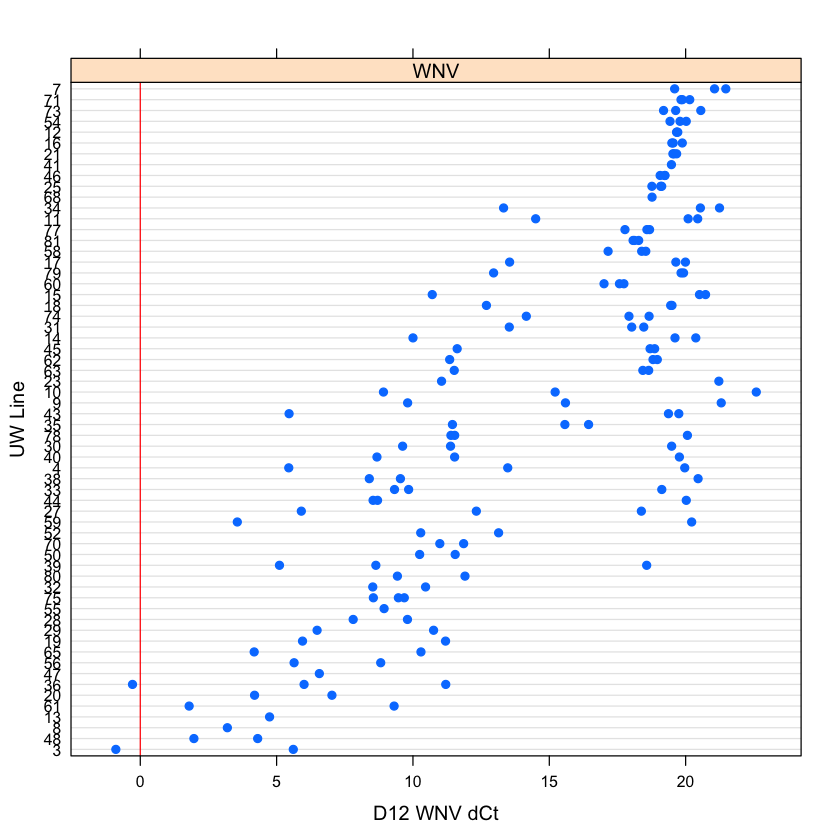

In [4]:
library(lattice)
dotplot(reorder(pheno[,'UW_Line'], pheno[,'dCt'], mean, na.rm=T) ~ 
        pheno[,'dCt'] | pheno[,'Virus'], 
        panel = function(x,y,...) {panel.dotplot(x,y,...); panel.abline(v=0, col.line="red")}, 
        pch=19, ylab='UW Line', xlab="D12 WNV dCt")

## Step 4. Update Phenotypes and Create Covariate Dataframe

In [5]:
## Sort pheno dataframe and set rownames
pheno = pheno[with(pheno, order(Mating, RIX_ID)),]
rownames(pheno) = pheno$ID

## Add sex column
pheno$sex = 'M'

In [ ]:
## Correct the mismatched matings (shouldn't be necessary anymore)
#pheno$Mating[pheno$Mating == '3609x5119'] = '3609x15119'
#pheno$Mating[pheno$Mating == '8018x3154'] = '18018x3154'
#pheno$Mating[pheno$Mating == '8036x18018'] = '8036x8018'
#pheno$Mating[pheno$Mating == '16012x15119'] = '16012x5119'
#pheno$Mating[pheno$Mating == '5119x8018'] = '15119x8018'
#pheno$Mating[pheno$Mating == '8042x16513'] = '18042x16513'

## Re-create IDs
#pheno$ID = paste0(pheno$Mating, '_', pheno$RIX_ID)

## Set rownames
#rownames(pheno) = pheno$ID

In [6]:
## Create covariate dataframe (must include sex)
covar = data.frame(sex = as.numeric(pheno$sex == 'M'))
rownames(covar) = pheno$ID

In [7]:
## Get IDs and Matings for each sample
samples = pheno$ID
matings = unlist(lapply(strsplit(samples, '_'), function(x) {x[1]}))
matings = unique(matings)

## Step 4. Get Marker Probabilities for Each Sample

In [10]:
## Read strain ID mapping file (with Oas1b status for WNV mapping analyses)
strain_map = read.delim(file.path('./data', 'Oas1b_status_recoded.txt'), header=T, as.is=T, sep='\t')

head(strain_map)

,Mating,CC_Mating,UW_Line,A,B,C,D,E,F,G,H,CW_prob,P_prob,Null_prob,Oas1b_status,Oas1b,Oas1b_High,Oas1b_Mod,Oas1b_Low
1,13067x16912,CC003xCC051,17,1e-20,1e-20,1e-20,1e-20,0.5,1e-20,1e-20,0.5,0.5,1e-20,0.5,High-Low,High,1,0,0
2,13067x5306,CC003xCC062,63,1e-20,1e-20,1.995e-07,0.4999998005,1e-20,1e-20,1e-20,0.5,0.5,1e-20,0.5,High-Low,High,1,0,0
3,13140x16680,CC001xCC055,48,1e-20,0.5,1e-20,1e-20,0.5,1e-20,1e-20,1e-20,2e-20,1e-20,1,Low,Low,0,0,1
4,13140x3015,CC001xCC074,2,1e-20,0.5,0.5,1e-20,1e-20,1e-20,1e-20,1e-20,2e-20,1e-20,1,Low,Low,0,0,1
5,13421x16034,CC007xCC070,78,1e-20,1e-20,1.156e-06,0.499998844,1e-20,1e-20,0.5,1e-20,2e-20,0.5,0.5,Mod-Low,Mod,0,1,0
6,13421x16296,CC007xCC049,NA,1e-20,0.125,1.2215e-06,0.8749987785,1e-20,1e-20,1e-20,1e-20,2e-20,1e-20,1,Low,Low,0,0,1


In [11]:
## Check that matings match the strain mapping file
setdiff(matings, strain_map$Mating)

character(0)

In [12]:
## Update covar with Oas1b
covar$Mating = pheno$Mating
covar$Oas1b = sapply(covar$Mating, function(x) {if (x %in% strain_map$Mating) strain_map$Oas1b[strain_map$Mating == x] else NA})
covar$Oas1b_High = sapply(covar$Mating, function(x) {if (x %in% strain_map$Mating) strain_map$Oas1b_High[strain_map$Mating == x] else NA})
covar$Oas1b_Mod = sapply(covar$Mating, function(x) {if (x %in% strain_map$Mating) strain_map$Oas1b_Mod[strain_map$Mating == x] else NA})
covar$Oas1b_Low = sapply(covar$Mating, function(x) {if (x %in% strain_map$Mating) strain_map$Oas1b_Low[strain_map$Mating == x] else NA})
pheno$Oas1b = covar$Oas1b
pheno$Oas1b_High = covar$Oas1b_High
pheno$Oas1b_Mod = covar$Oas1b_Mod
pheno$Oas1b_Low = covar$Oas1b_Low

## Step 5. Construct 3D Array of Probabilities

In [14]:
## Load universal model probabilities (loads a model.probs object containing all RIX lines)
data_dir = './xdata'
load(file.path(data_dir, 'rix_universal_model_prob_males_27-Jun-2016.rda'))

In [15]:
## Create custom model.probs array
model.probs = model.probs[pheno$Mating, , ]
dimnames(model.probs)[[1]] = pheno$ID

In [16]:
## Check model.probs object
dim(model.probs)
names(dimnames(model.probs))
dim(model.probs)[1] == dim(pheno)[1]
model.probs[1,,1:5]

[1]   158     8 76600

[1] "samples"  "founders" "markers"

[1] TRUE

,UNC6,JAX00000010,JAX00240603,JAX00240610,JAX00240613
A,6.00e-06,5.25e-06,4.50e-06,3.75e-06,3.00e-06
B,0.4999962,0.4999970,0.4999977,0.4999981,0.4999985
C,4.2e-08,1.0e-20,1.0e-20,1.0e-20,1.0e-20
D,4.2e-08,1.0e-20,1.0e-20,1.0e-20,1.0e-20
E,0.4999961,0.4999970,0.4999977,0.4999981,0.4999985
F,4.2e-08,1.0e-20,1.0e-20,1.0e-20,1.0e-20
G,4.2e-08,1.0e-20,1.0e-20,1.0e-20,1.0e-20
H,1.50075e-06,7.50750e-07,7.50000e-10,7.50000e-10,1.00000e-20


In [ ]:
## Fix very small genotype probabilities
model.probs[model.probs < 0.005] = 1e-20

In [ ]:
## Check model.probs object
model.probs[1,,1:5]

## Step 6. Calculate Kinship Matrix

In [17]:
## Create kinship probability matrix
K = kinship.probs(model.probs)

SNP 0
SNP 1000
SNP 2000
SNP 3000
SNP 4000
SNP 5000
SNP 6000
SNP 7000
SNP 8000
SNP 9000
SNP 10000
SNP 11000
SNP 12000
SNP 13000
SNP 14000
SNP 15000
SNP 16000
SNP 17000
SNP 18000
SNP 19000
SNP 20000
SNP 21000
SNP 22000
SNP 23000
SNP 24000
SNP 25000
SNP 26000
SNP 27000
SNP 28000
SNP 29000
SNP 30000
SNP 31000
SNP 32000
SNP 33000
SNP 34000
SNP 35000
SNP 36000
SNP 37000
SNP 38000
SNP 39000
SNP 40000
SNP 41000
SNP 42000
SNP 43000
SNP 44000
SNP 45000
SNP 46000
SNP 47000
SNP 48000
SNP 49000
SNP 50000
SNP 51000
SNP 52000
SNP 53000
SNP 54000
SNP 55000
SNP 56000
SNP 57000
SNP 58000
SNP 59000
SNP 60000
SNP 61000
SNP 62000
SNP 63000
SNP 64000
SNP 65000
SNP 66000
SNP 67000
SNP 68000
SNP 69000
SNP 70000
SNP 71000
SNP 72000
SNP 73000
SNP 74000
SNP 75000
SNP 76000


In [18]:
## Garbage collection might help free memory
gc()

,used,(Mb),gc trigger,(Mb),max used,(Mb)
Ncells,4036993.0,215.6,6861544.0,366.5,5211120.0,278.4
Vcells,99671586.0,760.5,393992108.0,3006.0,487229801.0,3717.3


In [19]:
## Check kinship matrix
K[1:5, 1:5]

,13067x16912_133,13067x16912_134,13067x16912_135,13067x5306_47,13067x5306_58
13067x16912_133,1.0000000,1.0000000,1.0000000,0.5946484,0.5946484
13067x16912_134,1.0000000,1.0000000,1.0000000,0.5946484,0.5946484
13067x16912_135,1.0000000,1.0000000,1.0000000,0.5946484,0.5946484
13067x5306_47,0.5946484,0.5946484,0.5946484,1.0000000,1.0000000
13067x5306_58,0.5946484,0.5946484,0.5946484,1.0000000,1.0000000


## Step 7. Perform QTL Scan

In [20]:
## First get marker positions
marker_pos = read.csv(file.path(data_dir, 'CC001-Uncb38V01.csv'), as.is=T)
marker_pos = marker_pos[,1:3]
marker_pos$position_cM = NA
head(marker_pos)

,marker,chromosome,position.B38.,position_cM
1,UNC6,1,3010274,NA
2,JAX00000010,1,3135418,NA
3,JAX00240603,1,3252796,NA
4,JAX00240610,1,3266608,NA
5,JAX00240613,1,3323400,NA
6,JAX00240636,1,3389563,NA


In [21]:
## Run QTL scan
qtl = scanone(pheno=pheno, pheno.col='dCt', probs=model.probs, K=K, 
              addcovar=covar[, c('sex'), drop=F], snps=marker_pos)

[1] "Mapping with 158 samples."
[1] "Mapping with 76600 markers."
[1] "dCt"


In [22]:
## Run permutations to calculate significance threshold
## Note: nperm=10 for demonstration purposes only. Normally, at least 1000 permutations should be done.
perms = scanone.perm(pheno=pheno, pheno.col='dCt', probs=model.probs, 
                     addcovar=covar[, c('sex'), drop=F], snps=marker_pos, nperm = 10)

[1] "dCt"
[1] "1 of 10"
[1] "2 of 10"
[1] "3 of 10"
[1] "4 of 10"
[1] "5 of 10"
[1] "6 of 10"
[1] "7 of 10"
[1] "8 of 10"
[1] "9 of 10"
[1] "10 of 10"


In [23]:
thr = quantile(perms, probs = 0.95)
thr

95% 
9.032614

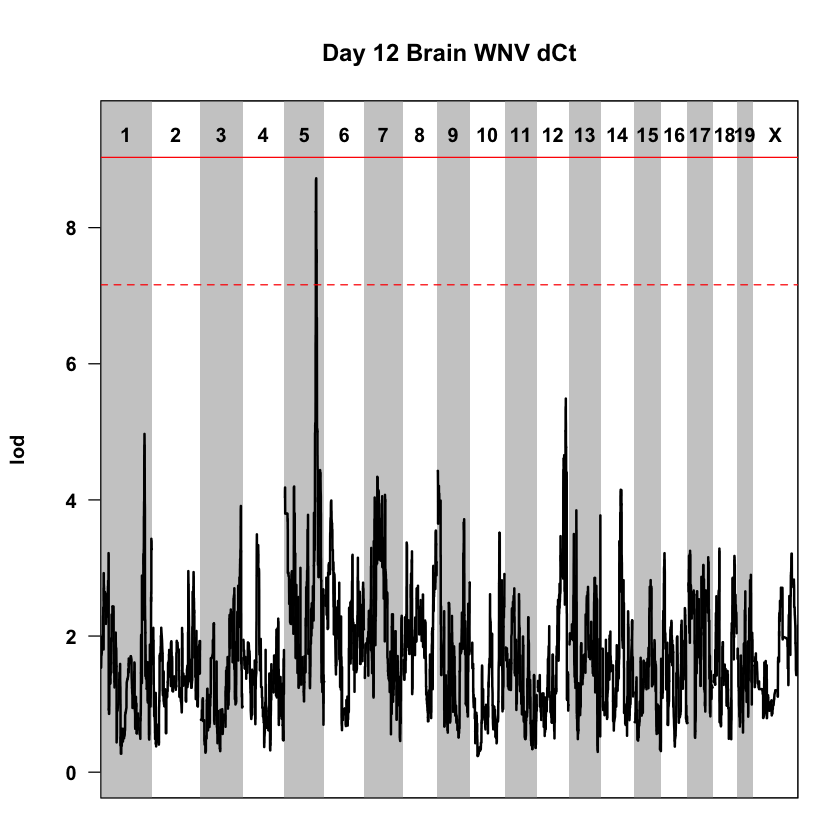

In [27]:
## Plot QTL results
plot(qtl, sig.thr = thr, main = 'Day 12 Brain WNV dCt')
abline(h=quantile(perms, probs = 0.90), lty=2, col='red')

## Step 8. Identify QTL Intervals

In [28]:
## Identify the Bayes Credible Interval for the peak on chromosome 5
interval = bayesint_v2(qtl, chr = 5)
interval

,marker,chromosome,position.B38.,position_cM,perc.var,lrs,lod,p,neg.log10.p
23173,UNC10027338,5,119.898431,NA,19.758938,34.7813,7.55266337783703,1.22940866759537e-05,4.91030372933492
23255,UNC10043432,5,121.263782,NA,22.453782,40.178779,8.72471095794802,1.16339706775978e-06,5.9342720351374
23291,UNC10062151,5,122.900748,NA,18.063093,31.476864,6.83511416481982,5.07631993283242e-05,4.29445101449594


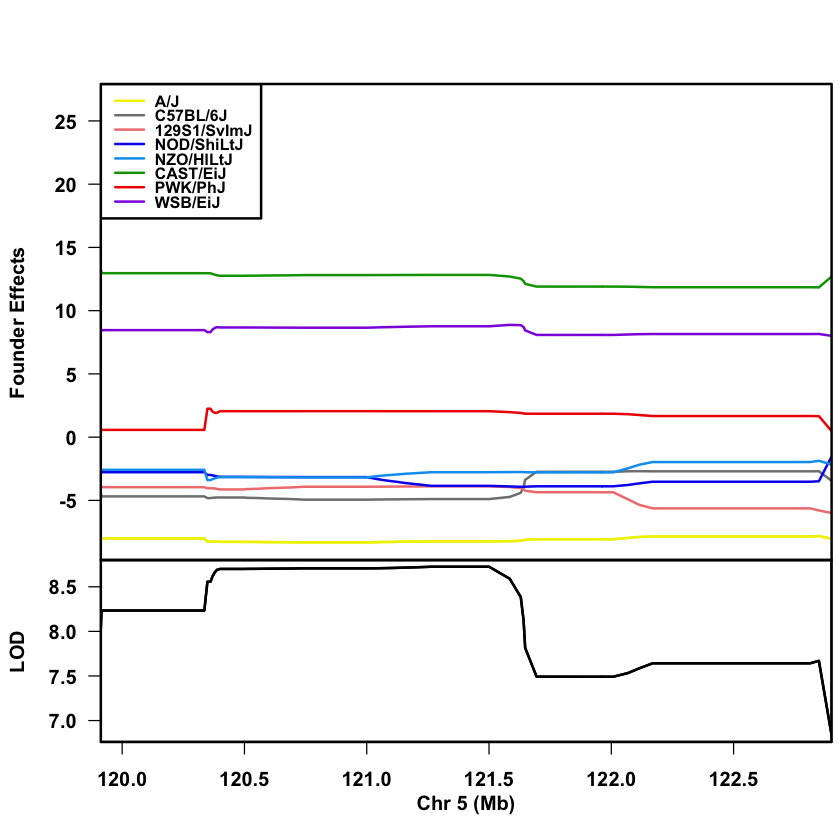

In [29]:
coefplot_v2(qtl, chr=5, start=interval[1,3], end=interval[3,3])

In [30]:
## Get marker at peak
get_min_marker(qtl, chr=5)

,marker,chromosome,position.B38.,position_cM,perc.var,lrs,lod,p,neg.log10.p
23255,UNC10043432,5,121.263782,NA,22.4537821680971,40.1787787849058,8.72471095794802,1.16339706775978e-06,5.9342720351374


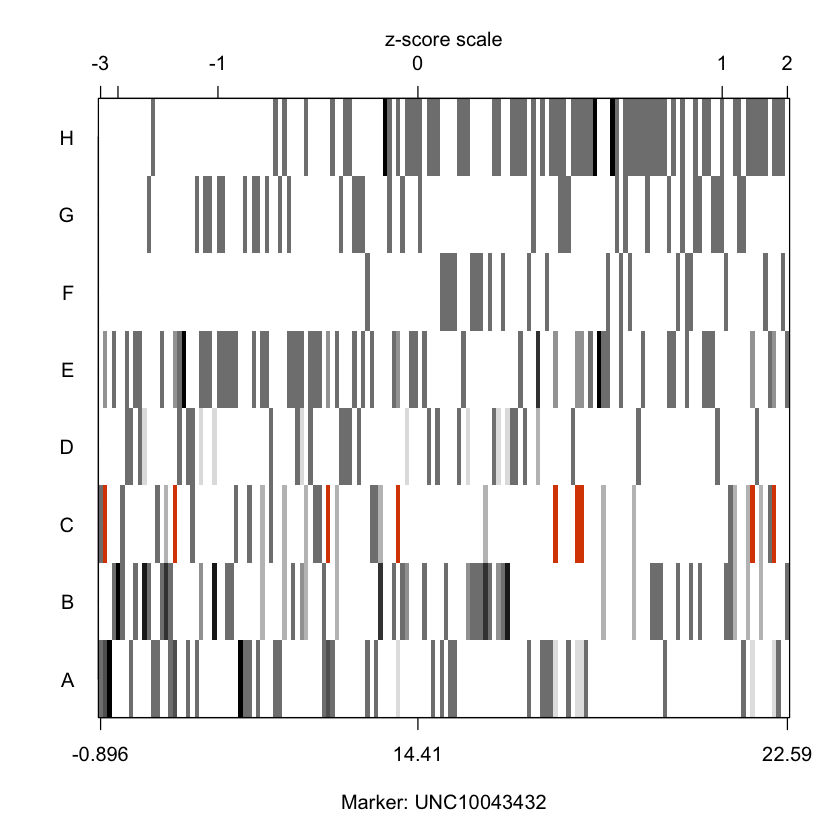

In [31]:
## Create probability plot
prob.plot(pheno, 'dCt', model.probs, 'UNC10043432')